In [1]:
import torch.cuda
import sys

sys.path.append('..')
SEED=1

from src.henry.mnist_vae_pure import VariationalAutoencoder
import torchvision
import torchvision.datasets as datasets
import pickle
from matplotlib import pyplot as plt
import numpy as np
from utils import * 
from federated_pure import federate




In [2]:
class FakeArgs:
    def __init__(self):
        self.seed=1
        self.epochs = 20
        self.dataset = "mnist"
        self.num_users=10
        self.iid = 2
        self.dirichlet = 0.5
        self.local_ep=10
        self.local_bs=32
    

In [3]:
# vae, ovr_losses, mse_losses, kl_losses = vae.train_model(dataset_train,16,10)
# print(mse_losses)
# print(kl_losses)
# 46 -> 34
res = federate(FakeArgs())
res.serialise("orig_test",FakeArgs())





/home/henry/anaconda3/envs/rp/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
  0%|          | 0/20 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 19876.62871785802
Finished local epoch 2 out of 10, average loss across batches: 18097.741783802903
Finished local epoch 3 out of 10, average loss across batches: 17720.207223486712
Finished local epoch 4 out of 10, average loss across batches: 17520.792618879183
Finished local epoch 5 out of 10, average loss across batches: 17349.616537739912
Finished local epoch 6 out of 10, average loss across batches: 17219.444974163387
Finished local epoch 7 out of 10, average loss across batches: 17108.22681625246
Finished local epoch 8 out of 10, average loss across batches: 17035.384104330707
Finished local epoch 9 out of 10, average loss across batches: 16967.6258419968
Finished local epoch 10 out of 10, average loss across batches: 16919.909291184795
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 19236.921282087053
Finished local

  5%|▌         | 1/20 [01:24<26:44, 84.45s/it]

Finished local epoch 10 out of 10, average loss across batches: 17361.4568101671

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 18137.708826740894
Finished local epoch 2 out of 10, average loss across batches: 17363.78643270177
Finished local epoch 3 out of 10, average loss across batches: 17220.134085107038
Finished local epoch 4 out of 10, average loss across batches: 17093.03402589813
Finished local epoch 5 out of 10, average loss across batches: 16992.529977392962
Finished local epoch 6 out of 10, average loss across batches: 16921.491014856052
Finished local epoch 7 out of 10, average loss across batches: 16859.60152020792
Finished local epoch 8 out of 10, average loss across batches: 16787.157211183563
Finished local epoch 9 out of 10, average loss across batches: 16738.12030557948
Finished local epoch 10 out of 10, average loss across batches: 16697.33428426427
Training user 1 in round 2
Finished local e

 10%|█         | 2/20 [02:48<25:11, 83.96s/it]

Finished local epoch 10 out of 10, average loss across batches: 16737.33490193685

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 17463.255232683317
Finished local epoch 2 out of 10, average loss across batches: 17025.282564899113
Finished local epoch 3 out of 10, average loss across batches: 16862.25381397638
Finished local epoch 4 out of 10, average loss across batches: 16757.898106852856
Finished local epoch 5 out of 10, average loss across batches: 16689.15948726624
Finished local epoch 6 out of 10, average loss across batches: 16644.494598148376
Finished local epoch 7 out of 10, average loss across batches: 16584.99799304872
Finished local epoch 8 out of 10, average loss across batches: 16534.630474901576
Finished local epoch 9 out of 10, average loss across batches: 16472.946800412155
Finished local epoch 10 out of 10, average loss across batches: 16465.635273129923
Training user 1 in round 3
Finished loca

 15%|█▌        | 3/20 [04:10<23:37, 83.40s/it]

Finished local epoch 10 out of 10, average loss across batches: 16420.585981580945

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 17100.893919937254
Finished local epoch 2 out of 10, average loss across batches: 16756.85171628937
Finished local epoch 3 out of 10, average loss across batches: 16626.46543968381
Finished local epoch 4 out of 10, average loss across batches: 16532.31860543799
Finished local epoch 5 out of 10, average loss across batches: 16477.16541969119
Finished local epoch 6 out of 10, average loss across batches: 16415.108982837108
Finished local epoch 7 out of 10, average loss across batches: 16368.52981206939
Finished local epoch 8 out of 10, average loss across batches: 16342.985101654773
Finished local epoch 9 out of 10, average loss across batches: 16328.760707584892
Finished local epoch 10 out of 10, average loss across batches: 16287.157149667815
Training user 1 in round 4
Finished local

 20%|██        | 4/20 [05:32<22:05, 82.87s/it]

Finished local epoch 10 out of 10, average loss across batches: 16250.68688015408

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 16819.314518485484
Finished local epoch 2 out of 10, average loss across batches: 16565.33936315822
Finished local epoch 3 out of 10, average loss across batches: 16447.779850516734
Finished local epoch 4 out of 10, average loss across batches: 16378.921844242126
Finished local epoch 5 out of 10, average loss across batches: 16321.188022883858
Finished local epoch 6 out of 10, average loss across batches: 16314.214589997538
Finished local epoch 7 out of 10, average loss across batches: 16272.981276144194
Finished local epoch 8 out of 10, average loss across batches: 16271.080781711367
Finished local epoch 9 out of 10, average loss across batches: 16226.353150375246
Finished local epoch 10 out of 10, average loss across batches: 16237.043633889025
Training user 1 in round 5
Finished lo

 25%|██▌       | 5/20 [06:56<20:45, 83.02s/it]

Finished local epoch 10 out of 10, average loss across batches: 16155.95115424262

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 16654.38418507013
Finished local epoch 2 out of 10, average loss across batches: 16460.19853054257
Finished local epoch 3 out of 10, average loss across batches: 16391.31080062746
Finished local epoch 4 out of 10, average loss across batches: 16276.338171290601
Finished local epoch 5 out of 10, average loss across batches: 16238.748800442914
Finished local epoch 6 out of 10, average loss across batches: 16206.167657326525
Finished local epoch 7 out of 10, average loss across batches: 16190.239180917815
Finished local epoch 8 out of 10, average loss across batches: 16154.177026943898
Finished local epoch 9 out of 10, average loss across batches: 16122.521768885335
Finished local epoch 10 out of 10, average loss across batches: 16096.38505398007
Training user 1 in round 6
Finished local

 30%|███       | 6/20 [08:19<19:22, 83.03s/it]

Finished local epoch 10 out of 10, average loss across batches: 16107.437763129341

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 16510.871632012797
Finished local epoch 2 out of 10, average loss across batches: 16381.590470441683
Finished local epoch 3 out of 10, average loss across batches: 16312.198853500246
Finished local epoch 4 out of 10, average loss across batches: 16254.632385734498
Finished local epoch 5 out of 10, average loss across batches: 16184.058351531743
Finished local epoch 6 out of 10, average loss across batches: 16150.809881735975
Finished local epoch 7 out of 10, average loss across batches: 16106.588228961615
Finished local epoch 8 out of 10, average loss across batches: 16099.548789677658
Finished local epoch 9 out of 10, average loss across batches: 16053.551723209892
Finished local epoch 10 out of 10, average loss across batches: 16032.655792476624
Training user 1 in round 7
Finished 

 35%|███▌      | 7/20 [09:53<18:46, 86.63s/it]

Finished local epoch 10 out of 10, average loss across batches: 16036.4533074273

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 16421.643008735235
Finished local epoch 2 out of 10, average loss across batches: 16284.581046998032
Finished local epoch 3 out of 10, average loss across batches: 16229.976197250246
Finished local epoch 4 out of 10, average loss across batches: 16179.382647176428
Finished local epoch 5 out of 10, average loss across batches: 16182.268981453002
Finished local epoch 6 out of 10, average loss across batches: 16137.425677442176
Finished local epoch 7 out of 10, average loss across batches: 16123.891736128198
Finished local epoch 8 out of 10, average loss across batches: 16078.458042415108
Finished local epoch 9 out of 10, average loss across batches: 16039.48210660679
Finished local epoch 10 out of 10, average loss across batches: 16026.315668061023
Training user 1 in round 8
Finished loc

 40%|████      | 8/20 [11:25<17:41, 88.43s/it]

Finished local epoch 10 out of 10, average loss across batches: 15972.324584960938

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 16358.526651697835
Finished local epoch 2 out of 10, average loss across batches: 16241.772207185038
Finished local epoch 3 out of 10, average loss across batches: 16198.16717289001
Finished local epoch 4 out of 10, average loss across batches: 16173.406526820867
Finished local epoch 5 out of 10, average loss across batches: 16134.882770207923
Finished local epoch 6 out of 10, average loss across batches: 16087.299539400836
Finished local epoch 7 out of 10, average loss across batches: 16083.766905296507
Finished local epoch 8 out of 10, average loss across batches: 16091.06809793307
Finished local epoch 9 out of 10, average loss across batches: 16097.764986774115
Finished local epoch 10 out of 10, average loss across batches: 16065.764783003198
Training user 1 in round 9
Finished lo

 45%|████▌     | 9/20 [12:47<15:51, 86.54s/it]

Finished local epoch 10 out of 10, average loss across batches: 15943.252010769314

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 16269.632916307824
Finished local epoch 2 out of 10, average loss across batches: 16166.340778020423
Finished local epoch 3 out of 10, average loss across batches: 16098.453817052165
Finished local epoch 4 out of 10, average loss across batches: 16075.72646253691
Finished local epoch 5 out of 10, average loss across batches: 16076.021053764764
Finished local epoch 6 out of 10, average loss across batches: 16081.7954832062
Finished local epoch 7 out of 10, average loss across batches: 16009.47846179872
Finished local epoch 8 out of 10, average loss across batches: 16028.516432394194
Finished local epoch 9 out of 10, average loss across batches: 16057.582215797243
Finished local epoch 10 out of 10, average loss across batches: 16033.64316636934
Training user 1 in round 10
Finished lo

 50%|█████     | 10/20 [14:10<14:12, 85.23s/it]

Finished local epoch 10 out of 10, average loss across batches: 15880.681386990018

 | Global Training Round : 11 |

Training user 0 in round 11
Finished local epoch 1 out of 10, average loss across batches: 16246.058409202757
Finished local epoch 2 out of 10, average loss across batches: 16168.711510365403
Finished local epoch 3 out of 10, average loss across batches: 16131.128625584399
Finished local epoch 4 out of 10, average loss across batches: 16089.801723209892
Finished local epoch 5 out of 10, average loss across batches: 16090.14098640502
Finished local epoch 6 out of 10, average loss across batches: 16023.146326740896
Finished local epoch 7 out of 10, average loss across batches: 16014.842169814223
Finished local epoch 8 out of 10, average loss across batches: 16013.808985912894
Finished local epoch 9 out of 10, average loss across batches: 15978.266178641732
Finished local epoch 10 out of 10, average loss across batches: 15946.765567328986
Training user 1 in round 11
Finishe

 55%|█████▌    | 11/20 [15:32<12:38, 84.26s/it]

Finished local epoch 10 out of 10, average loss across batches: 15865.06680094401

 | Global Training Round : 12 |

Training user 0 in round 12
Finished local epoch 1 out of 10, average loss across batches: 16193.163478100394
Finished local epoch 2 out of 10, average loss across batches: 16075.12348901944
Finished local epoch 3 out of 10, average loss across batches: 16042.564845287894
Finished local epoch 4 out of 10, average loss across batches: 15995.33659879429
Finished local epoch 5 out of 10, average loss across batches: 15971.607617956446
Finished local epoch 6 out of 10, average loss across batches: 15974.568082554133
Finished local epoch 7 out of 10, average loss across batches: 15946.229315329725
Finished local epoch 8 out of 10, average loss across batches: 15936.759042814962
Finished local epoch 9 out of 10, average loss across batches: 15947.53744386688
Finished local epoch 10 out of 10, average loss across batches: 15975.545783095473
Training user 1 in round 12
Finished l

 60%|██████    | 12/20 [16:54<11:09, 83.63s/it]

Finished local epoch 10 out of 10, average loss across batches: 15867.02470703125

 | Global Training Round : 13 |

Training user 0 in round 13
Finished local epoch 1 out of 10, average loss across batches: 16172.869644285187
Finished local epoch 2 out of 10, average loss across batches: 16100.32501460999
Finished local epoch 3 out of 10, average loss across batches: 16047.257454939714
Finished local epoch 4 out of 10, average loss across batches: 16009.844922643946
Finished local epoch 5 out of 10, average loss across batches: 15970.08171598179
Finished local epoch 6 out of 10, average loss across batches: 15944.457654096948
Finished local epoch 7 out of 10, average loss across batches: 15944.654508335383
Finished local epoch 8 out of 10, average loss across batches: 15958.190518116387
Finished local epoch 9 out of 10, average loss across batches: 15915.636937899852
Finished local epoch 10 out of 10, average loss across batches: 15919.233210045522
Training user 1 in round 13
Finished 

 65%|██████▌   | 13/20 [18:17<09:43, 83.37s/it]

Finished local epoch 10 out of 10, average loss across batches: 15836.462485080296

 | Global Training Round : 14 |

Training user 0 in round 14
Finished local epoch 1 out of 10, average loss across batches: 16164.122520146408
Finished local epoch 2 out of 10, average loss across batches: 16077.88613050566
Finished local epoch 3 out of 10, average loss across batches: 16030.506697527067
Finished local epoch 4 out of 10, average loss across batches: 16008.65069820374
Finished local epoch 5 out of 10, average loss across batches: 15987.440625768946
Finished local epoch 6 out of 10, average loss across batches: 15951.958719088336
Finished local epoch 7 out of 10, average loss across batches: 15956.12944835753
Finished local epoch 8 out of 10, average loss across batches: 15967.132435716043
Finished local epoch 9 out of 10, average loss across batches: 15915.001872385581
Finished local epoch 10 out of 10, average loss across batches: 15895.357925535187
Training user 1 in round 14
Finished 

 70%|███████   | 14/20 [19:39<08:19, 83.19s/it]

Finished local epoch 10 out of 10, average loss across batches: 15827.774839274089

 | Global Training Round : 15 |

Training user 0 in round 15
Finished local epoch 1 out of 10, average loss across batches: 16118.501995417077
Finished local epoch 2 out of 10, average loss across batches: 16036.430775559793
Finished local epoch 3 out of 10, average loss across batches: 16032.700579785926
Finished local epoch 4 out of 10, average loss across batches: 16020.599832369586
Finished local epoch 5 out of 10, average loss across batches: 16031.04075418307
Finished local epoch 6 out of 10, average loss across batches: 15960.813768762304
Finished local epoch 7 out of 10, average loss across batches: 15936.059412678396
Finished local epoch 8 out of 10, average loss across batches: 15941.68181363804
Finished local epoch 9 out of 10, average loss across batches: 15916.206116203248
Finished local epoch 10 out of 10, average loss across batches: 15906.651113435038
Training user 1 in round 15
Finished

 75%|███████▌  | 15/20 [21:02<06:54, 82.93s/it]

Finished local epoch 10 out of 10, average loss across batches: 15810.821679009332

 | Global Training Round : 16 |

Training user 0 in round 16
Finished local epoch 1 out of 10, average loss across batches: 16138.969868817667
Finished local epoch 2 out of 10, average loss across batches: 16024.832154281496
Finished local epoch 3 out of 10, average loss across batches: 15989.131255382628
Finished local epoch 4 out of 10, average loss across batches: 15953.940125953493
Finished local epoch 5 out of 10, average loss across batches: 15940.681183101624
Finished local epoch 6 out of 10, average loss across batches: 15979.592823419045
Finished local epoch 7 out of 10, average loss across batches: 15930.944720410926
Finished local epoch 8 out of 10, average loss across batches: 15881.997104915108
Finished local epoch 9 out of 10, average loss across batches: 15863.108621432086
Finished local epoch 10 out of 10, average loss across batches: 15845.745167169045
Training user 1 in round 16
Finish

 80%|████████  | 16/20 [22:25<05:31, 82.87s/it]

Finished local epoch 10 out of 10, average loss across batches: 15788.897526041666

 | Global Training Round : 17 |

Training user 0 in round 17
Finished local epoch 1 out of 10, average loss across batches: 16146.218007966288
Finished local epoch 2 out of 10, average loss across batches: 16062.802322988435
Finished local epoch 3 out of 10, average loss across batches: 15983.28635965182
Finished local epoch 4 out of 10, average loss across batches: 15982.108194666585
Finished local epoch 5 out of 10, average loss across batches: 15934.536905604085
Finished local epoch 6 out of 10, average loss across batches: 15901.568697711615
Finished local epoch 7 out of 10, average loss across batches: 15908.727654404527
Finished local epoch 8 out of 10, average loss across batches: 15898.596406711367
Finished local epoch 9 out of 10, average loss across batches: 15907.89289339321
Finished local epoch 10 out of 10, average loss across batches: 15884.719618909941
Training user 1 in round 17
Finished

 85%|████████▌ | 17/20 [23:47<04:08, 82.82s/it]

Finished local epoch 10 out of 10, average loss across batches: 15798.048509385852

 | Global Training Round : 18 |

Training user 0 in round 18
Finished local epoch 1 out of 10, average loss across batches: 16108.621016855315
Finished local epoch 2 out of 10, average loss across batches: 15999.348063791831
Finished local epoch 3 out of 10, average loss across batches: 16014.38808363066
Finished local epoch 4 out of 10, average loss across batches: 16022.409702571358
Finished local epoch 5 out of 10, average loss across batches: 15972.117072157973
Finished local epoch 6 out of 10, average loss across batches: 15913.169345164863
Finished local epoch 7 out of 10, average loss across batches: 15918.022157203493
Finished local epoch 8 out of 10, average loss across batches: 15944.462021715059
Finished local epoch 9 out of 10, average loss across batches: 15903.718473179133
Finished local epoch 10 out of 10, average loss across batches: 15855.424835445374
Training user 1 in round 18
Finishe

 90%|█████████ | 18/20 [25:10<02:45, 82.81s/it]

Finished local epoch 10 out of 10, average loss across batches: 15837.534208170573

 | Global Training Round : 19 |

Training user 0 in round 19
Finished local epoch 1 out of 10, average loss across batches: 16101.115730345718
Finished local epoch 2 out of 10, average loss across batches: 16052.46381336122
Finished local epoch 3 out of 10, average loss across batches: 15995.53037340059
Finished local epoch 4 out of 10, average loss across batches: 15942.49509027436
Finished local epoch 5 out of 10, average loss across batches: 15928.729811300444
Finished local epoch 6 out of 10, average loss across batches: 15903.968311700295
Finished local epoch 7 out of 10, average loss across batches: 15890.32388425812
Finished local epoch 8 out of 10, average loss across batches: 15871.71355191929
Finished local epoch 9 out of 10, average loss across batches: 15868.714905265748
Finished local epoch 10 out of 10, average loss across batches: 15857.768985297736
Training user 1 in round 19
Finished lo

 95%|█████████▌| 19/20 [26:32<01:22, 82.66s/it]

Finished local epoch 10 out of 10, average loss across batches: 15833.312877061631

 | Global Training Round : 20 |

Training user 0 in round 20
Finished local epoch 1 out of 10, average loss across batches: 16085.875999630905
Finished local epoch 2 out of 10, average loss across batches: 15977.259669506644
Finished local epoch 3 out of 10, average loss across batches: 15960.493256336122
Finished local epoch 4 out of 10, average loss across batches: 15905.29700187623
Finished local epoch 5 out of 10, average loss across batches: 15897.809754859743
Finished local epoch 6 out of 10, average loss across batches: 15892.023029958169
Finished local epoch 7 out of 10, average loss across batches: 15940.205835537648
Finished local epoch 8 out of 10, average loss across batches: 15862.960110882135
Finished local epoch 9 out of 10, average loss across batches: 15833.305775559793
Finished local epoch 10 out of 10, average loss across batches: 15835.953355684054
Training user 1 in round 20
Finishe

100%|██████████| 20/20 [27:55<00:00, 83.76s/it]

Finished local epoch 10 out of 10, average loss across batches: 15792.830919731989


In [6]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to('cuda')
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

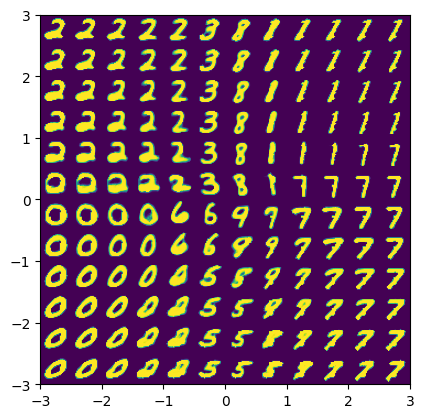

In [7]:
plot_reconstructed(res.global_model, r0=(-3, 3), r1=(-3, 3))


In [11]:
trial_weights = calculate_new_weights(res.global_model.encoder, res.client_datasets, 0.1)


In [12]:
second_res = federate(FakeArgs(), trial_weights, res.client_datasets)
second_res.serialise("point_one",FakeArgs())


  0%|          | 0/20 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 19876.62871785802
Finished local epoch 2 out of 10, average loss across batches: 18097.741783802903
Finished local epoch 3 out of 10, average loss across batches: 17720.207223486712
Finished local epoch 4 out of 10, average loss across batches: 17520.792618879183
Finished local epoch 5 out of 10, average loss across batches: 17349.616537739912
Finished local epoch 6 out of 10, average loss across batches: 17219.444974163387
Finished local epoch 7 out of 10, average loss across batches: 17108.22681625246
Finished local epoch 8 out of 10, average loss across batches: 17035.384104330707
Finished local epoch 9 out of 10, average loss across batches: 16967.6258419968
Finished local epoch 10 out of 10, average loss across batches: 16919.909291184795
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 19236.921282087053
Finished local

  5%|▌         | 1/20 [01:24<26:40, 84.23s/it]

Finished local epoch 10 out of 10, average loss across batches: 17361.4568101671

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 18179.27454093873
Finished local epoch 2 out of 10, average loss across batches: 17478.302638256642
Finished local epoch 3 out of 10, average loss across batches: 17328.537140132874
Finished local epoch 4 out of 10, average loss across batches: 17200.224924643207
Finished local epoch 5 out of 10, average loss across batches: 17093.116649237203
Finished local epoch 6 out of 10, average loss across batches: 17022.04397991511
Finished local epoch 7 out of 10, average loss across batches: 16976.390809547243
Finished local epoch 8 out of 10, average loss across batches: 16901.968277097687
Finished local epoch 9 out of 10, average loss across batches: 16851.51840089813
Finished local epoch 10 out of 10, average loss across batches: 16792.446861927903
Training user 1 in round 2
Finished local

 10%|█         | 2/20 [02:48<25:12, 84.05s/it]

Finished local epoch 10 out of 10, average loss across batches: 16889.319057888453

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 17393.185873677412
Finished local epoch 2 out of 10, average loss across batches: 17003.98291015625
Finished local epoch 3 out of 10, average loss across batches: 16878.812826802412
Finished local epoch 4 out of 10, average loss across batches: 16800.119617372045
Finished local epoch 5 out of 10, average loss across batches: 16761.015548105315
Finished local epoch 6 out of 10, average loss across batches: 16689.3655150406
Finished local epoch 7 out of 10, average loss across batches: 16657.51703601747
Finished local epoch 8 out of 10, average loss across batches: 16592.32635257751
Finished local epoch 9 out of 10, average loss across batches: 16565.042276697834
Finished local epoch 10 out of 10, average loss across batches: 16546.725862758365
Training user 1 in round 3
Finished local

 15%|█▌        | 3/20 [04:11<23:44, 83.79s/it]

Finished local epoch 10 out of 10, average loss across batches: 16530.77406616211

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 17066.026697834644
Finished local epoch 2 out of 10, average loss across batches: 16761.218138687254
Finished local epoch 3 out of 10, average loss across batches: 16660.65789554626
Finished local epoch 4 out of 10, average loss across batches: 16596.751238004428
Finished local epoch 5 out of 10, average loss across batches: 16558.183597594736
Finished local epoch 6 out of 10, average loss across batches: 16508.140709584153
Finished local epoch 7 out of 10, average loss across batches: 16481.377083845964
Finished local epoch 8 out of 10, average loss across batches: 16447.245394008365
Finished local epoch 9 out of 10, average loss across batches: 16417.96685070128
Finished local epoch 10 out of 10, average loss across batches: 16410.573073019194
Training user 1 in round 4
Finished loc

 20%|██        | 4/20 [05:34<22:14, 83.39s/it]

Finished local epoch 10 out of 10, average loss across batches: 16368.350634765626

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 16839.621497447097
Finished local epoch 2 out of 10, average loss across batches: 16598.629329170766
Finished local epoch 3 out of 10, average loss across batches: 16524.37046321358
Finished local epoch 4 out of 10, average loss across batches: 16476.694312869095
Finished local epoch 5 out of 10, average loss across batches: 16441.551092673475
Finished local epoch 6 out of 10, average loss across batches: 16389.684331938977
Finished local epoch 7 out of 10, average loss across batches: 16391.4812992126
Finished local epoch 8 out of 10, average loss across batches: 16368.774694728101
Finished local epoch 9 out of 10, average loss across batches: 16318.138456569883
Finished local epoch 10 out of 10, average loss across batches: 16310.701214167077
Training user 1 in round 5
Finished loc

 25%|██▌       | 5/20 [06:56<20:43, 82.88s/it]

Finished local epoch 10 out of 10, average loss across batches: 16209.272205946181

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 16721.52401421014
Finished local epoch 2 out of 10, average loss across batches: 16534.105899360235
Finished local epoch 3 out of 10, average loss across batches: 16443.180479515257
Finished local epoch 4 out of 10, average loss across batches: 16421.75989250123
Finished local epoch 5 out of 10, average loss across batches: 16359.770776943898
Finished local epoch 6 out of 10, average loss across batches: 16333.476547121063
Finished local epoch 7 out of 10, average loss across batches: 16317.31205785556
Finished local epoch 8 out of 10, average loss across batches: 16297.965951033464
Finished local epoch 9 out of 10, average loss across batches: 16277.761960968257
Finished local epoch 10 out of 10, average loss across batches: 16268.671536663385
Training user 1 in round 6
Finished loc

 30%|███       | 6/20 [08:18<19:17, 82.68s/it]

Finished local epoch 10 out of 10, average loss across batches: 16138.655495876736

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 16607.413162832185
Finished local epoch 2 out of 10, average loss across batches: 16427.48721241388
Finished local epoch 3 out of 10, average loss across batches: 16361.448492095227
Finished local epoch 4 out of 10, average loss across batches: 16323.483394592766
Finished local epoch 5 out of 10, average loss across batches: 16309.66450464444
Finished local epoch 6 out of 10, average loss across batches: 16290.068547766978
Finished local epoch 7 out of 10, average loss across batches: 16237.599451740896
Finished local epoch 8 out of 10, average loss across batches: 16236.632012795275
Finished local epoch 9 out of 10, average loss across batches: 16221.888068251723
Finished local epoch 10 out of 10, average loss across batches: 16187.500811238928
Training user 1 in round 7
Finished lo

 35%|███▌      | 7/20 [09:41<17:53, 82.58s/it]

Finished local epoch 10 out of 10, average loss across batches: 16065.310228135852

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 16549.155588705707
Finished local epoch 2 out of 10, average loss across batches: 16384.47327909695
Finished local epoch 3 out of 10, average loss across batches: 16345.581023929626
Finished local epoch 4 out of 10, average loss across batches: 16296.153816283218
Finished local epoch 5 out of 10, average loss across batches: 16263.864234744095
Finished local epoch 6 out of 10, average loss across batches: 16245.26442159818
Finished local epoch 7 out of 10, average loss across batches: 16238.239649975394
Finished local epoch 8 out of 10, average loss across batches: 16189.206004705955
Finished local epoch 9 out of 10, average loss across batches: 16161.634761780266
Finished local epoch 10 out of 10, average loss across batches: 16158.547374815453
Training user 1 in round 8
Finished lo

 40%|████      | 8/20 [11:03<16:29, 82.42s/it]

Finished local epoch 10 out of 10, average loss across batches: 16022.234702555339

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 16467.022722379428
Finished local epoch 2 out of 10, average loss across batches: 16316.88124769316
Finished local epoch 3 out of 10, average loss across batches: 16246.355603315698
Finished local epoch 4 out of 10, average loss across batches: 16227.999227208415
Finished local epoch 5 out of 10, average loss across batches: 16197.042388195128
Finished local epoch 6 out of 10, average loss across batches: 16186.32476085753
Finished local epoch 7 out of 10, average loss across batches: 16147.280680979331
Finished local epoch 8 out of 10, average loss across batches: 16144.873573603592
Finished local epoch 9 out of 10, average loss across batches: 16115.664919875739
Finished local epoch 10 out of 10, average loss across batches: 16092.143769992617
Training user 1 in round 9
Finished lo

 45%|████▌     | 9/20 [12:25<15:07, 82.52s/it]

Finished local epoch 10 out of 10, average loss across batches: 15966.12379896376

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 16421.883812130905
Finished local epoch 2 out of 10, average loss across batches: 16282.776693989912
Finished local epoch 3 out of 10, average loss across batches: 16210.807740218996
Finished local epoch 4 out of 10, average loss across batches: 16175.154773622047
Finished local epoch 5 out of 10, average loss across batches: 16175.400640532727
Finished local epoch 6 out of 10, average loss across batches: 16134.847983052412
Finished local epoch 7 out of 10, average loss across batches: 16117.124996155266
Finished local epoch 8 out of 10, average loss across batches: 16098.40100578248
Finished local epoch 9 out of 10, average loss across batches: 16084.08239265502
Finished local epoch 10 out of 10, average loss across batches: 16071.886611097441
Training user 1 in round 10
Finished 

 50%|█████     | 10/20 [13:48<13:45, 82.53s/it]

Finished local epoch 10 out of 10, average loss across batches: 15967.753696017795

 | Global Training Round : 11 |

Training user 0 in round 11
Finished local epoch 1 out of 10, average loss across batches: 16361.384619525099
Finished local epoch 2 out of 10, average loss across batches: 16225.811500369095
Finished local epoch 3 out of 10, average loss across batches: 16184.946688914863
Finished local epoch 4 out of 10, average loss across batches: 16129.003060408464
Finished local epoch 5 out of 10, average loss across batches: 16087.726216473917
Finished local epoch 6 out of 10, average loss across batches: 16095.243394746554
Finished local epoch 7 out of 10, average loss across batches: 16059.645457830955
Finished local epoch 8 out of 10, average loss across batches: 16086.587713767225
Finished local epoch 9 out of 10, average loss across batches: 16064.719495878446
Finished local epoch 10 out of 10, average loss across batches: 16057.779935100885
Training user 1 in round 11
Finish

 55%|█████▌    | 11/20 [15:11<12:23, 82.56s/it]

Finished local epoch 10 out of 10, average loss across batches: 15867.73093126085

 | Global Training Round : 12 |

Training user 0 in round 12
Finished local epoch 1 out of 10, average loss across batches: 16307.88620355561
Finished local epoch 2 out of 10, average loss across batches: 16215.865399698572
Finished local epoch 3 out of 10, average loss across batches: 16181.35736804872
Finished local epoch 4 out of 10, average loss across batches: 16133.714812992126
Finished local epoch 5 out of 10, average loss across batches: 16094.034879429133
Finished local epoch 6 out of 10, average loss across batches: 16099.631009319635
Finished local epoch 7 out of 10, average loss across batches: 16054.276574803149
Finished local epoch 8 out of 10, average loss across batches: 16042.167645792322
Finished local epoch 9 out of 10, average loss across batches: 16024.441779189223
Finished local epoch 10 out of 10, average loss across batches: 16002.008727546752
Training user 1 in round 12
Finished 

 60%|██████    | 12/20 [16:34<11:03, 82.89s/it]

Finished local epoch 10 out of 10, average loss across batches: 15814.498381212023

 | Global Training Round : 13 |

Training user 0 in round 13
Finished local epoch 1 out of 10, average loss across batches: 16314.073253721703
Finished local epoch 2 out of 10, average loss across batches: 16184.222279466043
Finished local epoch 3 out of 10, average loss across batches: 16178.690025990403
Finished local epoch 4 out of 10, average loss across batches: 16112.624227208415
Finished local epoch 5 out of 10, average loss across batches: 16093.161244309793
Finished local epoch 6 out of 10, average loss across batches: 16073.777597502462
Finished local epoch 7 out of 10, average loss across batches: 16045.73134534941
Finished local epoch 8 out of 10, average loss across batches: 16011.591385488435
Finished local epoch 9 out of 10, average loss across batches: 15997.173039954478
Finished local epoch 10 out of 10, average loss across batches: 15991.557290385088
Training user 1 in round 13
Finishe

 65%|██████▌   | 13/20 [17:58<09:41, 83.13s/it]

Finished local epoch 10 out of 10, average loss across batches: 15815.181264919705

 | Global Training Round : 14 |

Training user 0 in round 14
Finished local epoch 1 out of 10, average loss across batches: 16256.832115834153
Finished local epoch 2 out of 10, average loss across batches: 16155.828301857775
Finished local epoch 3 out of 10, average loss across batches: 16121.540142870324
Finished local epoch 4 out of 10, average loss across batches: 16057.320969949556
Finished local epoch 5 out of 10, average loss across batches: 16038.40285317729
Finished local epoch 6 out of 10, average loss across batches: 16014.821811946358
Finished local epoch 7 out of 10, average loss across batches: 16003.07465320497
Finished local epoch 8 out of 10, average loss across batches: 15991.576952356054
Finished local epoch 9 out of 10, average loss across batches: 15965.363688791831
Finished local epoch 10 out of 10, average loss across batches: 15968.885000153788
Training user 1 in round 14
Finished

 70%|███████   | 14/20 [19:20<08:17, 82.92s/it]

Finished local epoch 10 out of 10, average loss across batches: 15824.197302246093

 | Global Training Round : 15 |

Training user 0 in round 15
Finished local epoch 1 out of 10, average loss across batches: 16236.782926304133
Finished local epoch 2 out of 10, average loss across batches: 16137.955839382383
Finished local epoch 3 out of 10, average loss across batches: 16098.474913109007
Finished local epoch 4 out of 10, average loss across batches: 16076.007112758367
Finished local epoch 5 out of 10, average loss across batches: 16034.206758273867
Finished local epoch 6 out of 10, average loss across batches: 16009.152063084399
Finished local epoch 7 out of 10, average loss across batches: 15975.954151544045
Finished local epoch 8 out of 10, average loss across batches: 15974.911036694144
Finished local epoch 9 out of 10, average loss across batches: 16030.148406742126
Finished local epoch 10 out of 10, average loss across batches: 15983.038566529282
Training user 1 in round 15
Finish

 75%|███████▌  | 15/20 [20:43<06:53, 82.79s/it]

Finished local epoch 10 out of 10, average loss across batches: 15747.665761990018

 | Global Training Round : 16 |

Training user 0 in round 16
Finished local epoch 1 out of 10, average loss across batches: 16211.393062561516
Finished local epoch 2 out of 10, average loss across batches: 16115.239073265257
Finished local epoch 3 out of 10, average loss across batches: 16064.345483975148
Finished local epoch 4 out of 10, average loss across batches: 16028.388710322342
Finished local epoch 5 out of 10, average loss across batches: 16020.311707984743
Finished local epoch 6 out of 10, average loss across batches: 15996.74128398745
Finished local epoch 7 out of 10, average loss across batches: 15962.581608329232
Finished local epoch 8 out of 10, average loss across batches: 15995.498181440698
Finished local epoch 9 out of 10, average loss across batches: 15949.658710629921
Finished local epoch 10 out of 10, average loss across batches: 15925.078136534203
Training user 1 in round 16
Finishe

 80%|████████  | 16/20 [22:06<05:31, 82.88s/it]

Finished local epoch 10 out of 10, average loss across batches: 15719.028291829427

 | Global Training Round : 17 |

Training user 0 in round 17
Finished local epoch 1 out of 10, average loss across batches: 16186.06959737943
Finished local epoch 2 out of 10, average loss across batches: 16071.973817359743
Finished local epoch 3 out of 10, average loss across batches: 16058.583153912401
Finished local epoch 4 out of 10, average loss across batches: 16046.511053610975
Finished local epoch 5 out of 10, average loss across batches: 15995.624561700295
Finished local epoch 6 out of 10, average loss across batches: 15981.68549304872
Finished local epoch 7 out of 10, average loss across batches: 15948.923324464813
Finished local epoch 8 out of 10, average loss across batches: 15962.279673658957
Finished local epoch 9 out of 10, average loss across batches: 15915.11898683563
Finished local epoch 10 out of 10, average loss across batches: 15929.808870570867
Training user 1 in round 17
Finished 

 85%|████████▌ | 17/20 [23:30<04:09, 83.20s/it]

Finished local epoch 10 out of 10, average loss across batches: 15711.700915527344

 | Global Training Round : 18 |

Training user 0 in round 18
Finished local epoch 1 out of 10, average loss across batches: 16178.497950756644
Finished local epoch 2 out of 10, average loss across batches: 16055.530573326772
Finished local epoch 3 out of 10, average loss across batches: 16030.999473271408
Finished local epoch 4 out of 10, average loss across batches: 16012.240545798475
Finished local epoch 5 out of 10, average loss across batches: 15977.908087782973
Finished local epoch 6 out of 10, average loss across batches: 15960.223901943898
Finished local epoch 7 out of 10, average loss across batches: 15939.191521592027
Finished local epoch 8 out of 10, average loss across batches: 15932.329024667815
Finished local epoch 9 out of 10, average loss across batches: 15904.600828155757
Finished local epoch 10 out of 10, average loss across batches: 15890.049231822097
Training user 1 in round 18
Finish

 90%|█████████ | 18/20 [24:54<02:46, 83.39s/it]

Finished local epoch 10 out of 10, average loss across batches: 15675.300906032986

 | Global Training Round : 19 |

Training user 0 in round 19
Finished local epoch 1 out of 10, average loss across batches: 16152.435846764272
Finished local epoch 2 out of 10, average loss across batches: 16043.560792937993
Finished local epoch 3 out of 10, average loss across batches: 15998.831927442176
Finished local epoch 4 out of 10, average loss across batches: 15981.098025344489
Finished local epoch 5 out of 10, average loss across batches: 15976.235539954478
Finished local epoch 6 out of 10, average loss across batches: 15943.118783064714
Finished local epoch 7 out of 10, average loss across batches: 15935.193417046014
Finished local epoch 8 out of 10, average loss across batches: 15908.661959430365
Finished local epoch 9 out of 10, average loss across batches: 15898.952494463583
Finished local epoch 10 out of 10, average loss across batches: 15893.712994432824
Training user 1 in round 19
Finish

 95%|█████████▌| 19/20 [26:16<01:23, 83.08s/it]

Finished local epoch 10 out of 10, average loss across batches: 15677.104151746962

 | Global Training Round : 20 |

Training user 0 in round 20
Finished local epoch 1 out of 10, average loss across batches: 16126.658126230315
Finished local epoch 2 out of 10, average loss across batches: 16032.87749523253
Finished local epoch 3 out of 10, average loss across batches: 15995.905577171507
Finished local epoch 4 out of 10, average loss across batches: 15980.56569112943
Finished local epoch 5 out of 10, average loss across batches: 15952.508800596703
Finished local epoch 6 out of 10, average loss across batches: 15957.233106237696
Finished local epoch 7 out of 10, average loss across batches: 15937.442052165354
Finished local epoch 8 out of 10, average loss across batches: 15910.785579170768
Finished local epoch 9 out of 10, average loss across batches: 15888.627199187993
Finished local epoch 10 out of 10, average loss across batches: 15892.396226777804
Training user 1 in round 20
Finished

100%|██████████| 20/20 [27:38<00:00, 82.95s/it]

Finished local epoch 10 out of 10, average loss across batches: 15646.921664089627
